In [1]:
!tar -xf data.tar.gz

In [2]:
import os
import numpy as np
from dask.distributed import Client
from dask import delayed
import dask.array as da
from skimage.transform import resize
from skimage.color import rgb2gray

from skimage.io import imread, imread_collection, imsave, ImageCollection
import numpy as np
from skimage.transform import resize
from skimage.color import rgb2gray

import warnings
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt
%matplotlib inline

# Supervised Learning: City Versus Forest Classifier

In this demo, we will highlight the supervised learning classification models introduced to image datasets.  Before diving into the design safe data, let's try an easier classication problem. Here we will try to distinguish between pictures of streets in a city versus picture of a forest. This data is a reduced version of a [kaggle dataset](https://www.kaggle.com/puneet6060/intel-image-classification).


To get started see how much data we have in the training and testing sets:

In [3]:
# path to data
path = 'data'
path_train = path+'/Train/{}/'
path_test = path+'/Validation/{}/'

### get number of images per classes in test and train
classes = np.array(['city','forest'])
num_train = [len(os.listdir(path_train.format(i))) for i in classes]
num_test = [len(os.listdir(path_test.format(i))) for i in classes]

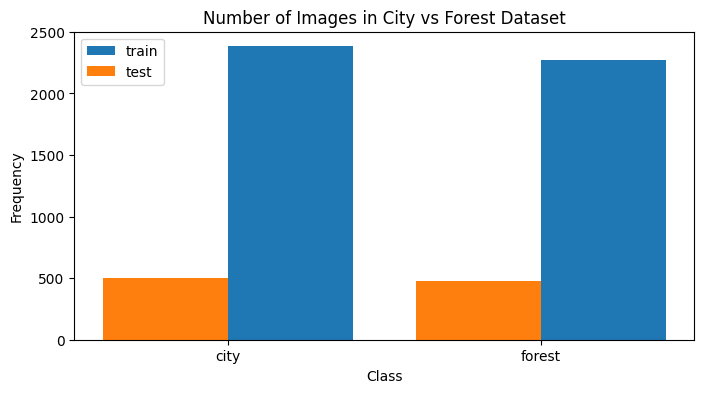

In [4]:
## plot results 
ticks = np.array([0,2])
fig,ax = plt.subplots(figsize=(8,4))
ax.bar(ticks+0.4,num_train,label='train')
ax.bar(ticks-0.4,num_test,label='test')
ax.set_xticks(ticks)
ax.set_xticklabels(classes)
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')
ax.legend()
ax.set_title('Number of Images in City vs Forest Dataset');

### Get Data from EDA pipeline

Next, let's import the data into our notebook.

In [5]:
client = Client()

In [6]:
from src.get_data_dask import get_all_data

classes = np.array(['city','forest'])
path_train = path+'/Train/{}/'
path_test = path+'/Validation/{}/'

path_list_train = [path_train.format(class_) for class_ in classes]
path_list_test = [path_test.format(class_) for class_ in classes]
        
train, test, y_train, y_test = get_all_data(path_list_train, path_list_test, classes, size=(112,112),gray=True)

data/Train/city/
data/Train/forest/
data/Validation/city/
data/Validation/forest/


In [7]:
X_train = train.compute()
X_test = test.compute()

In [8]:
client.close()

In [9]:
shape_train_all = X_train.shape
shape_test_all = X_test.shape 
shape_image = X_train[0].shape

In [10]:
shape_train_all, shape_image

((4653, 112, 112), (112, 112))

Here is an example of an image from each of the two classes

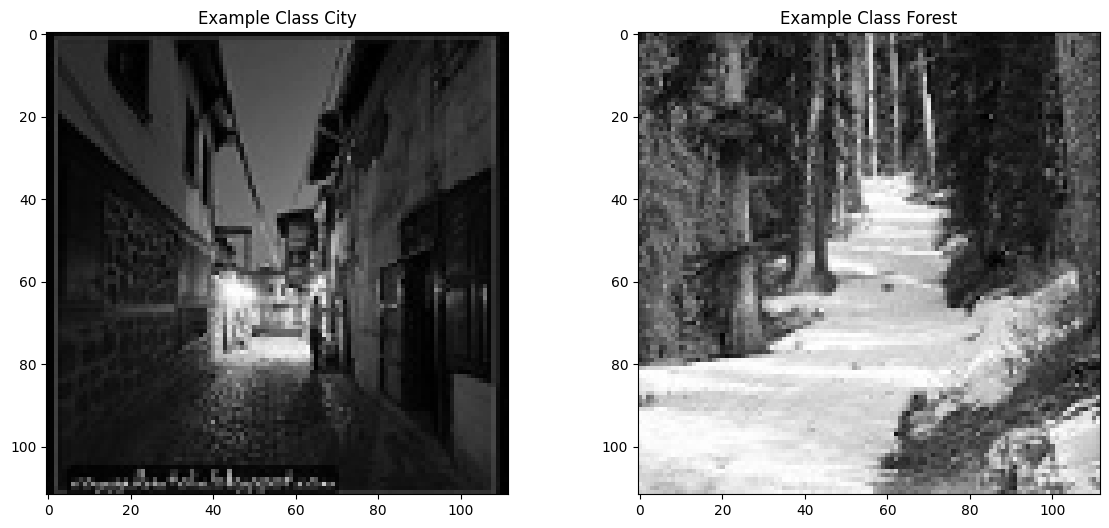

In [11]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
axs[0].imshow(X_train[0],cmap='gray')
axs[1].imshow(X_train[num_train[0]],cmap='gray')
axs[0].set_title('Example Class City')
axs[1].set_title('Example Class Forest');

### Reshape data to classic feature and target

Finally let's convert the image matrices into vectors. 

In [12]:
X_train = X_train.reshape((len(X_train),-1))
X_test = X_test.reshape((len(X_test),-1))
X_train.shape,X_test.shape

((4653, 12544), (975, 12544))

Now that our data is in shape, we can use it to build a classification model. An import part of modelling is to evaluate the model.  Below, we created a function that will print out a few evaluation metrics after trying a model. 

### Function for Model Evaluation 



In [13]:
from sklearn.metrics import RocCurveDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

def evaluate(model, X_train, X_test, y_train, y_test, roc=True):
    """
    Computes and prints accuracy score on train and test data, and various metrics using testing data
    Plots the confusion matrix and ROC curve if requested
    """
    accuracy_test = accuracy_score(y_test, model.predict(X_test))
    print('Accuracy on the Test Data is {:.2f}'.format(accuracy_test))
    print('Accuracy on the Training Data is {:.2f}'.format(accuracy_score(y_train, model.predict(X_train))))
    if roc:
        svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test) 
    cm_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                                   cmap=plt.cm.Blues,normalize=None)
    return accuracy_test 
    print(classification_report(y_test, model.predict(X_test), target_names=classes))
    return accuracy_test 

Next, we will try 4 different models and evaluate their performance:
- decision tree
- logistic regression 
- support vector classifier 
- random forest

### Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 

clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier()

Accuracy on the Test Data is 0.69
Accuracy on the Training Data is 1.00


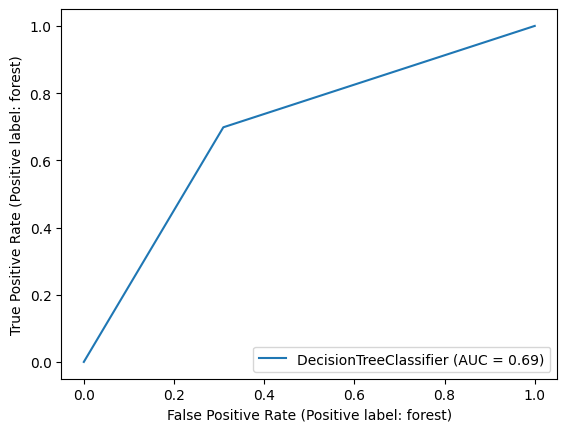

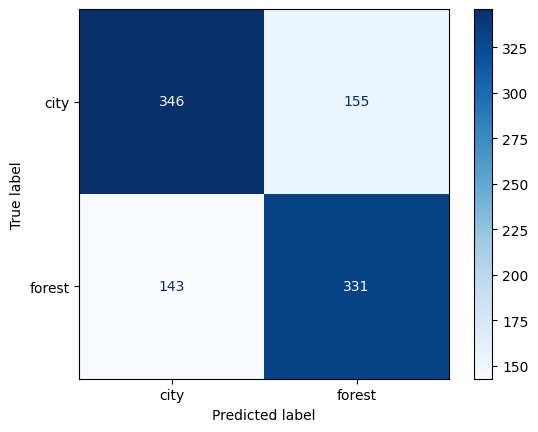

In [15]:
accuracy_dt = evaluate(clf_dt, X_train, X_test, y_train, y_test)

### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(random_state=0).fit(X_train, y_train)

Accuracy on the Test Data is 0.60
Accuracy on the Training Data is 0.96


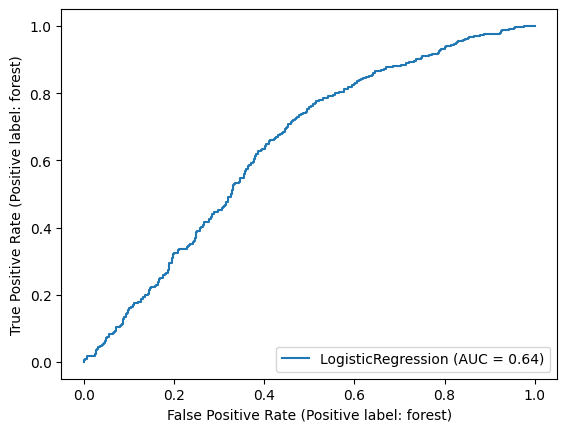

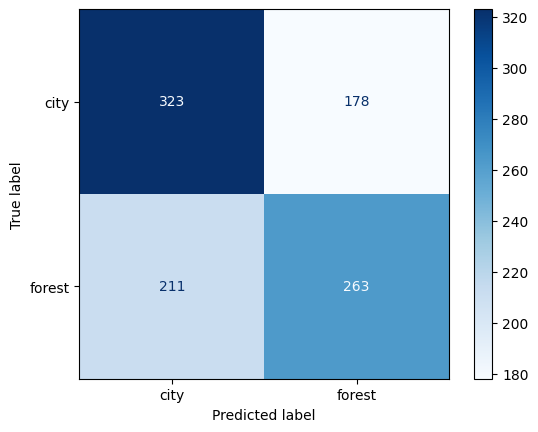

In [17]:
accuracy_lr = evaluate(clf_lr, X_train, X_test, y_train, y_test)

### Support Vector Machine Classifier

Below we standardize our data then use default sklearn parameters using the RBF kernel.

In [18]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf_svm = SVC(C=10).fit(X_train_scaled, y_train)

Accuracy on the Test Data is 0.80
Accuracy on the Training Data is 1.00


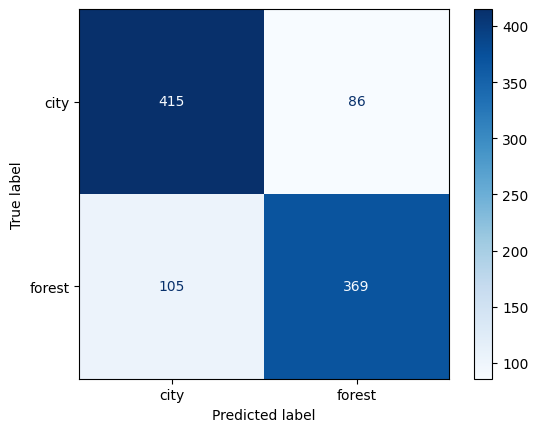

In [19]:
accuracy_svm = evaluate(clf_svm, X_train_scaled, X_test_scaled, y_train, y_test , roc=False)

### Naive Bayes Classifier

In [20]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train)

Accuracy on the Test Data is 0.73
Accuracy on the Training Data is 0.74


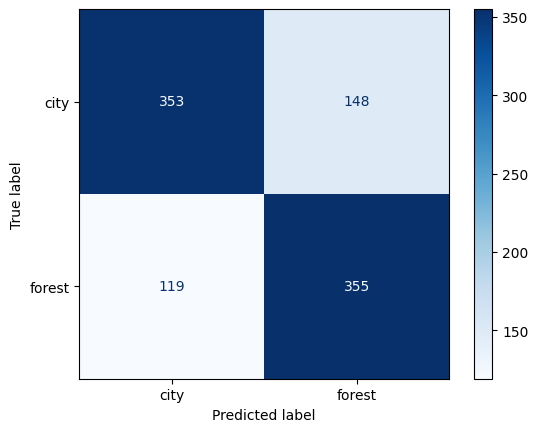

In [21]:
accuracy_nb = evaluate(gnb, X_train, X_test, y_train, y_test, roc=False )

### Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

RandomForestClassifier()

Accuracy on the Test Data is 0.82
Accuracy on the Training Data is 1.00


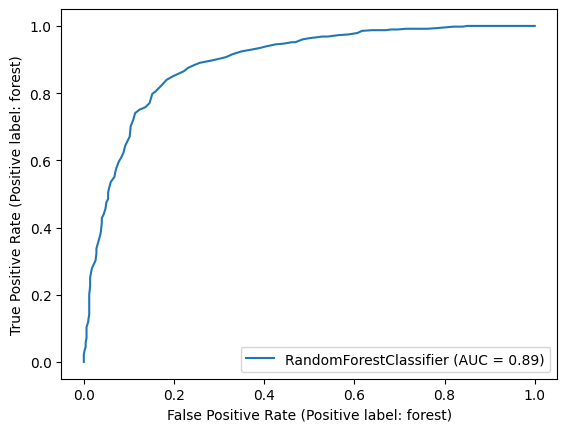

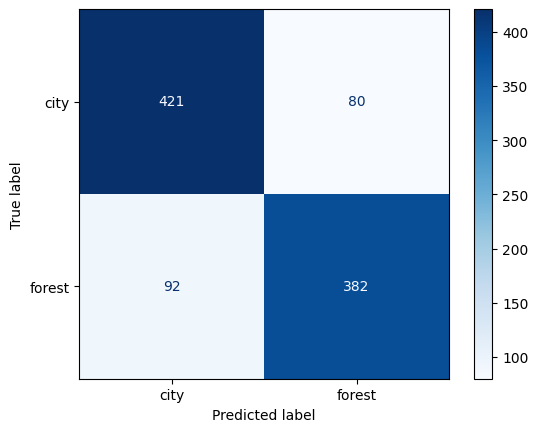

In [23]:
accuracy_rf = evaluate(clf_rf, X_train, X_test, y_train, y_test )

In [24]:
summary ='''
       Accuracy of all models: \n
       Decision Tree: {:.2f}\n
       Logistic Regression: {:.2f}\n
       Support Vector Machine: {:.2f} \n
       Naive Bayes: {:.2f} \n
       Random Forest {:.2f}
       '''.format(accuracy_dt, accuracy_lr, 
                  accuracy_svm, accuracy_nb, accuracy_rf)

print(summary)


       Accuracy of all models: 

       Decision Tree: 0.69

       Logistic Regression: 0.60

       Support Vector Machine: 0.80 

       Naive Bayes: 0.73 

       Random Forest 0.82
       


## Inspect where model failed 

Now that we have built models, we can see that the random forest model had the highest performance followed by SVM.  Next, let's look into what our model got right and wrong to see if we can understand how our model is making predictions.

In [25]:
yhat = clf_rf.predict(X_test)

misclassifications = X_test[y_test != yhat]
misclassifications.shape

(172, 12544)

### City Images Misclassified as Forest  

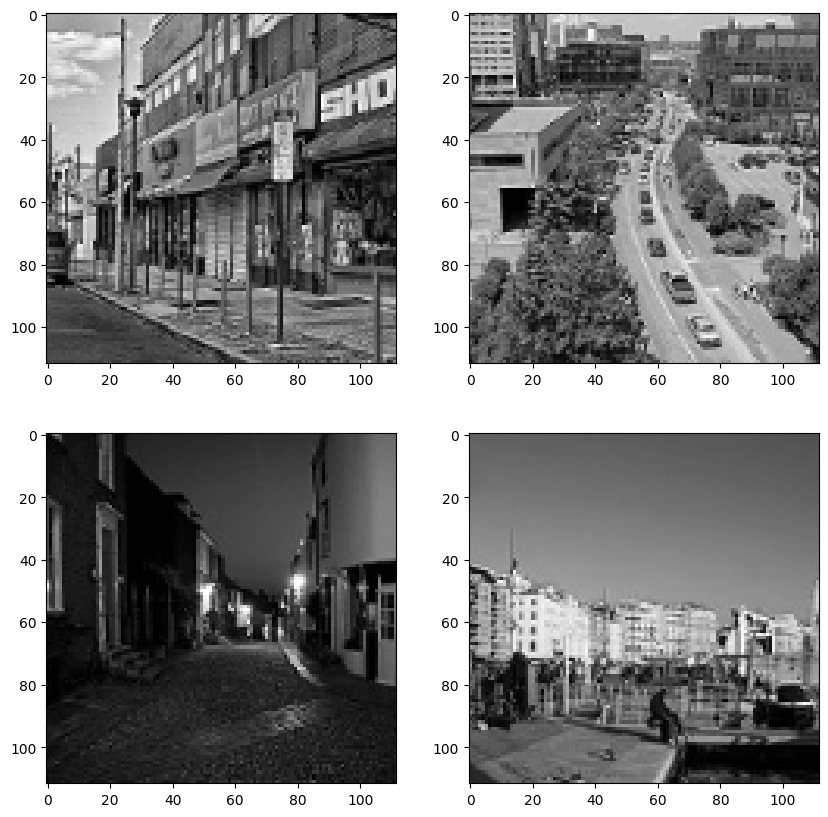

In [26]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
for i,ax in enumerate(ax.flatten()):
    ax.imshow(misclassifications[i].reshape(shape_image),cmap='gray')

### Forest Images Misclassified as City  

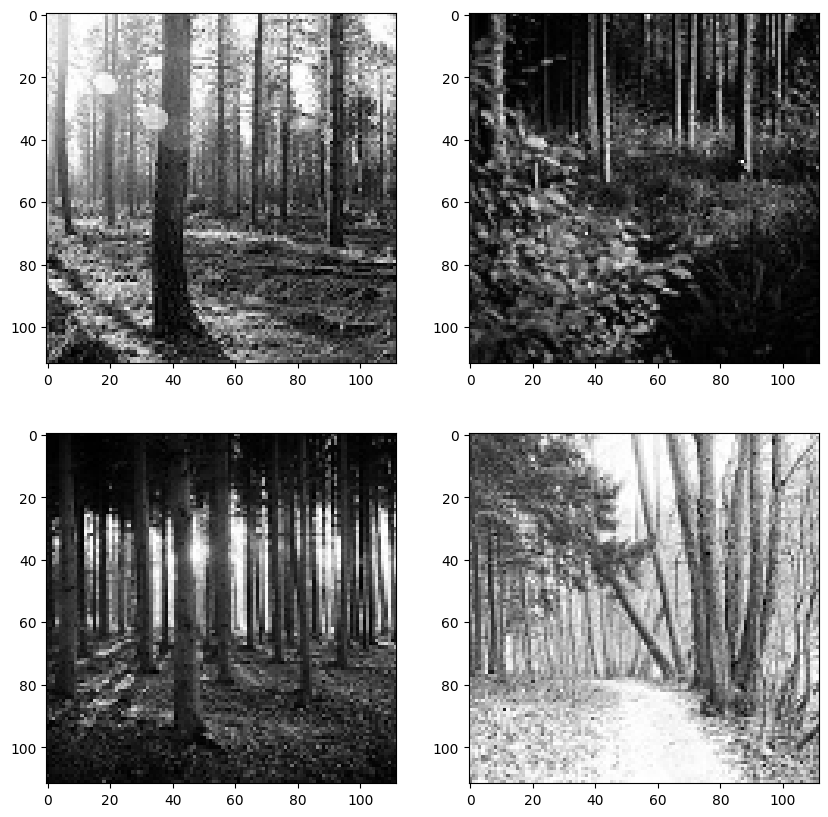

In [27]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
for i,ax in enumerate(ax.flatten()):
    ax.imshow(misclassifications[-(i+1)].reshape(shape_image),cmap='gray')

### City Images Correctly Classified

In [28]:
correct_classifications = X_test[y_test == yhat]
correct_classifications.shape

(803, 12544)

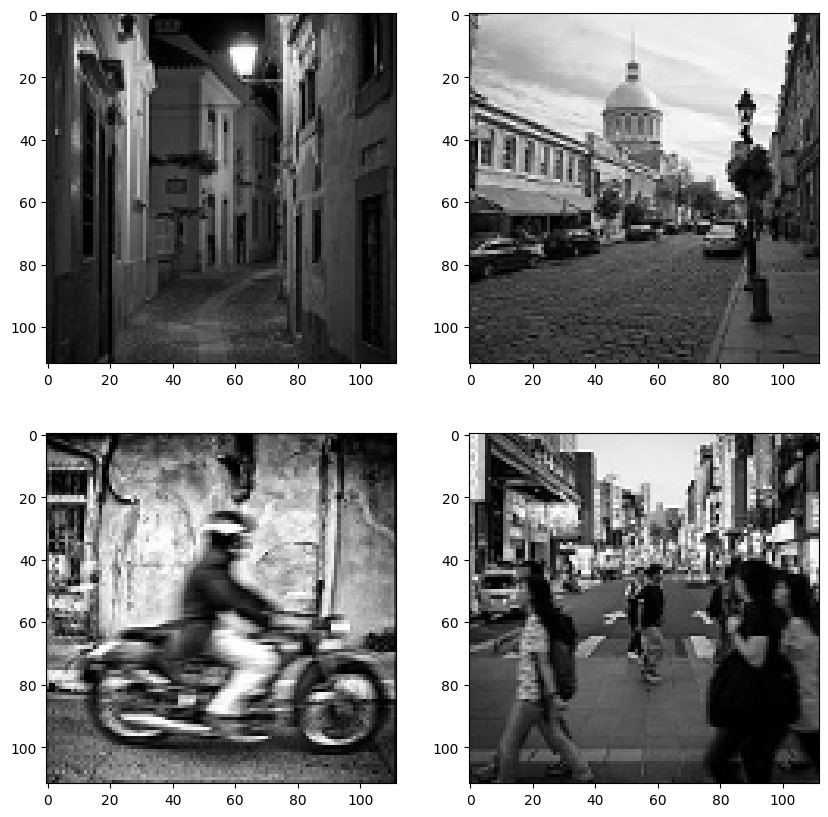

In [29]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
for i,ax in enumerate(ax.flatten()):
    ax.imshow(correct_classifications[i].reshape(shape_image),cmap='gray')

### Forest Images Correctly Classified

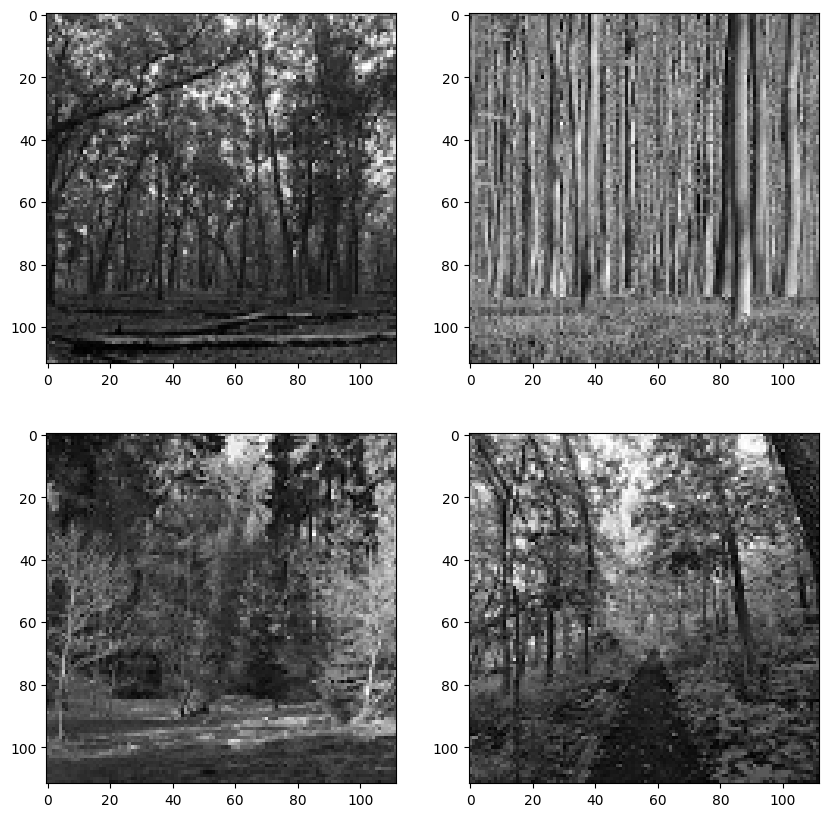

In [30]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
for i,ax in enumerate(ax.flatten()):
    ax.imshow(correct_classifications[-(i+1)].reshape(shape_image),cmap='gray')

**Question** What do you notice about the images that are classified correctly versus misclassified? 

## Feature Importance

Finally, we can take a look at feature importances to also get hints on how our model is making predictions. Below is a contour plot of the gini feature importances that can be computed with the random forest model.  How do you think the model is making decisions now? 

Text(0, 0.5, 'Feature Importance')

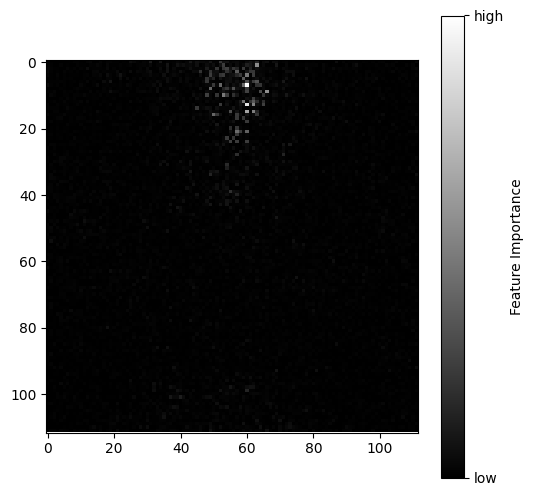

In [31]:
min_ = clf_rf.feature_importances_.min()
max_ = clf_rf.feature_importances_.max()

fig,ax = plt.subplots(figsize=(6,6))
cax = ax.imshow(clf_rf.feature_importances_.reshape((shape_image)),cmap='gray')
cbar = fig.colorbar(cax, ticks=[min_,max_])
cbar.ax.set_yticklabels(['low','high'])  # vertically oriented colorbar
cbar.ax.set_ylabel('Feature Importance')

It looks like our model has picked up on the sky during the day time in the upper middle part of a picture to distinguish between city streets and forest.  

**Question:** What is wrong with this way of making decisions? What would be a better way for a model to make decisions?

In the next notebook, we will try to same thing, but with the DesignSafe dataset.  How do you think the model will perform there? 

In [32]:
! rm -r data 